In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [27]:
from matplotlib.patches import Rectangle

def get_bounding_box_from_mask(mask):
    coords = np.argwhere(mask == True)
    if(coords.size == 0):
        return [(0, 0), (0, 0)] 
    
    xmin = np.min(coords[:,2])
    xmax = np.max(coords[:,2])

    ymin = np.min(coords[:,1])
    ymax = np.max(coords[:,1])
    return [(xmin, ymin), (xmax, ymax)]

def draw_bounding_box(coords, ax):
    xmin = coords[0][0]
    xmax = coords[1][0]

    ymin = coords[0][1]
    ymax = coords[1][1]
    height = ymax - ymin
    width = xmax - xmin
    ax.add_patch(Rectangle((xmin,ymin),width,height,
                edgecolor='red',
                facecolor='none',
                lw=0.5))

def draw_bounding_box_from_scaled_label(cx, cy, w, h, imageSize, ax):
    img_w = imageSize[0]
    img_h = imageSize[1]
    xmin = (cx - w/2) * img_w
    ymin = (cy - h/2) * img_h
    width = w * img_w
    height = h * img_h
    ax.add_patch(Rectangle((xmin,ymin),width,height,
            edgecolor='red',
            facecolor='none',
            lw=0.5))

In [8]:
def initialize_labels(id_list, positions, predictor, inference_state, frame_idx, prompts):
    for idx in range(0, len(id_list)):
        ann_obj_id = id_list[idx]
        points = np.array(positions[idx], dtype=np.float32)
        # for labels, `1` means positive click and `0` means negative click
        numClicks = points.shape[0]           
        labels = np.ones(numClicks)
        prompts[ann_obj_id] = points, labels
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )
    return out_obj_ids, out_mask_logits

In [9]:
def propagate_in_video(predictor, inference_state):
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    return video_segments

In [10]:
def convert_points_to_center_and_dimensions(coords):
    xmin = coords[0][0]
    xmax = coords[1][0]

    ymin = coords[0][1]
    ymax = coords[1][1]

    center_x = (xmin+xmax)/2
    center_y = (ymin + ymax)/2
    height = ymax - ymin
    width = xmax - xmin
    return center_x, center_y, width, height

def normalize_bounding_box_parameters(cx, cy, w, h, img_w, img_h):
    new_cx = cx / img_w
    new_cy = cy / img_h
    new_w = w / img_w
    new_h = h / img_h
    return new_cx, new_cy, new_w, new_h

In [11]:
def obtain_bounding_boxes(frame_names, video_segments, label_array):
    for out_frame_idx in range(0, len(frame_names)):
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            coords = get_bounding_box_from_mask(out_mask)
            cx, cy, w, h = convert_points_to_center_and_dimensions(coords)           
            label_array[out_frame_idx][out_obj_id][0] = cx
            label_array[out_frame_idx][out_obj_id][1] = cy
            label_array[out_frame_idx][out_obj_id][2] = w
            label_array[out_frame_idx][out_obj_id][3] = h

In [43]:
import os
def write_label_data_to_file(frame_name, output_dir, frame_labels):
    basename= os.path.splitext(os.path.basename(frame_name))[0]
    save_file_path = os.path.join(output_dir, basename + ".txt")
    print_buffer = []
    for object_idx in range(len(frame_labels)):
        label = frame_labels[object_idx]
        cx = label[0]
        cy = label[1]
        w = label[2]
        h = label[3]
        class_id = 1
        if(object_idx) == 0:
            class_id = 0

        # negative bounding box - not detected
        if(cx > 0 ):
            print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, cx, cy, w, h))
            
    print("\n".join(print_buffer), file= open(save_file_path, "w"))
    

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

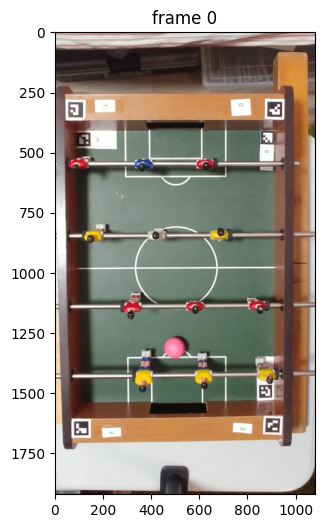

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/media/joseph/BC5EE56A5EE51E40/Users/littl/Documents/U of T M Eng/Fall 2024/CSC2529 Computational Imaging/project/videos/foosball_videos/20221004_220424_jpg/"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [7]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|███████████████████| 501/501 [00:23<00:00, 21.64it/s]


## Initialize the detection masks

In [14]:
# add the foosball men
# frames = np.array([522, 532, 544, 558], np.int32)
ann_frame_idx = 0  # the frame index we interact with

numFoosmen = 4
clicks_522_0 = [[500, 1312]]
clicks_522_1 = [[360, 1438], [368, 1371]]
clicks_522_2 = [[615, 1454], [609, 1373]]
clicks_522_3 = [[881, 1438], [854, 1384]]

clicks_522_4 = [[315, 1147], [330, 1116]]
clicks_522_5 = [[574, 1156], [578, 1131]]
clicks_522_6 = [[852, 1163], [817, 1119]]

clicks_522_7 = [[139, 857], [183, 818]]
clicks_522_8 = [[414, 857], [427, 832]]
clicks_522_9 = [[685, 831], [676, 862]]

clicks_522_10 = [[71, 557], [111, 535]]
clicks_522_11 = [[365, 568], [362, 543]]
clicks_522_12 = [[624, 560], [619, 541]]
# clicks_532 = [332, 1432]
# clicks_544 = [[368, 1411], [373, 1526]]
# clicks_558 = [[272, 1446], [270, 1374]]

# positions=[clicks_522_1, clicks_522_2, clicks_522_3, clicks_522_4, clicks_522_5, clicks_522_6]


In [15]:
num_frames = len(frame_names)
num_items = 13
label_array = np.zeros((num_frames, num_items, 4))

In [16]:
frame_idx = 0
id_list_0 = [0, 1, 2, 3, 4]
position_group_0 = [clicks_522_0, clicks_522_1, clicks_522_2, clicks_522_3, clicks_522_4]

id_list_1 = [5,6,7,8]
position_group_1 = [clicks_522_5, clicks_522_6, clicks_522_7, clicks_522_8]

id_list_2 = [9, 10, 11, 12]
position_group_2 = [clicks_522_9, clicks_522_10, clicks_522_11, clicks_522_12]

num_groups = 3

id_super_list = [id_list_0, id_list_1, id_list_2]
position_super_list = [position_group_0, position_group_1, position_group_2]

In [17]:
print(id_super_list)
print(position_super_list[0])
print(len(position_super_list[0]))

[[0, 1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
[[[500, 1312]], [[360, 1438], [368, 1371]], [[615, 1454], [609, 1373]], [[881, 1438], [854, 1384]], [[315, 1147], [330, 1116]]]
5


In [19]:
video_segments_super_list = {}
prompts = {}

for group_idx in range(0, num_groups):
    print("labelling group ", group_idx)
    predictor.reset_state(inference_state)
    positions = position_super_list[group_idx]
    id_list = id_super_list[group_idx]
    out_obj_ids, out_mask_logits = initialize_labels(id_list, positions, predictor, inference_state, frame_idx, prompts)
    video_segments = propagate_in_video(predictor, inference_state)
    video_segments_super_list[group_idx] = video_segments
    obtain_bounding_boxes(frame_names, video_segments, label_array)

labelling group  0


/media/joseph/BC5EE56A5EE51E40/Users/littl/Documents/U of T M Eng/Fall 2024/CSC2529 Computational Imaging/project/git/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/media/joseph/BC5EE56A5EE51E40/Users/littl/Documents/U of T M Eng/Fall 2024/CSC2529 Computational Imaging/project/git/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 501/501 [02:55<00:00,  2.85it/s]


labelling group  1


propagate in video: 100%|█████████████████████| 501/501 [02:38<00:00,  3.17it/s]


labelling group  2


propagate in video: 100%|█████████████████████| 501/501 [02:37<00:00,  3.18it/s]


In [21]:
negative_coords = np.argwhere(label_array == -1)
print(negative_coords)

[[430   0   0]
 [430   0   1]
 [431   0   0]
 [431   0   1]
 [432   0   0]
 [432   0   1]
 [433   0   0]
 [433   0   1]
 [434   0   0]
 [434   0   1]
 [435   0   0]
 [435   0   1]]


In [29]:
print(label_array[430][0])

[-1. -1.  0.  0.]


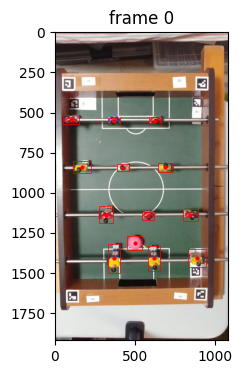

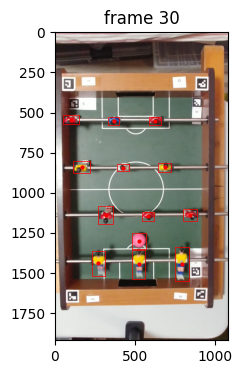

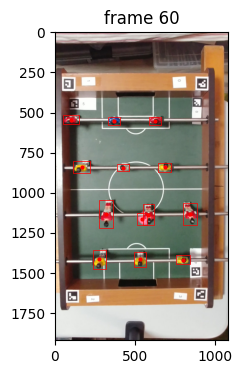

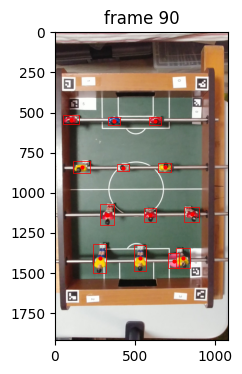

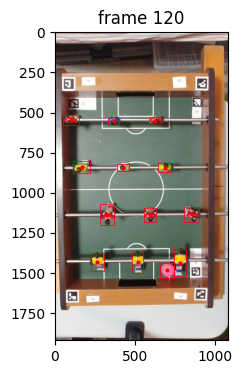

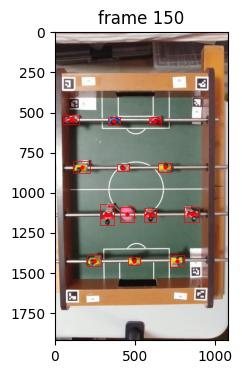

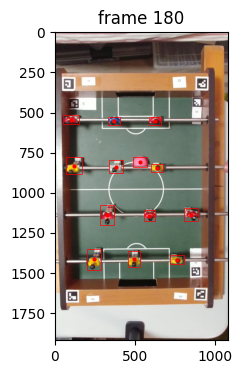

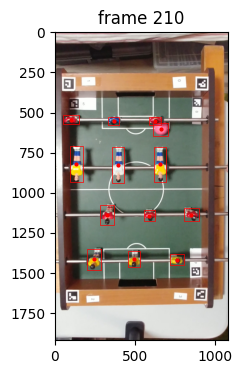

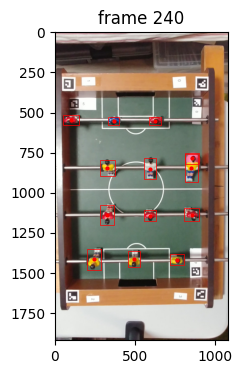

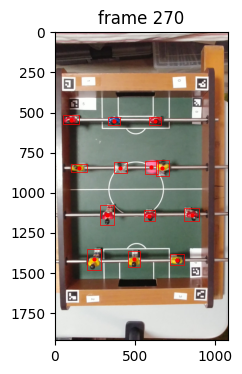

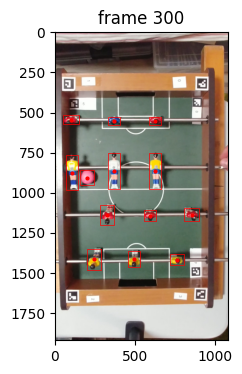

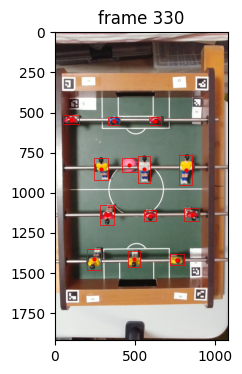

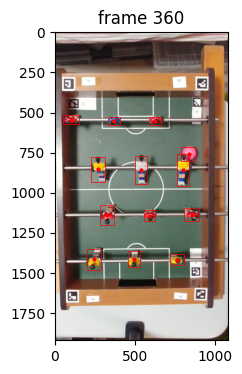

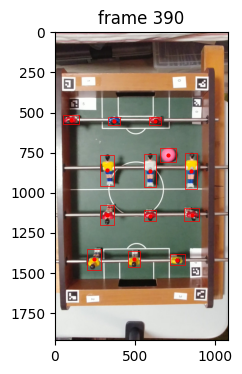

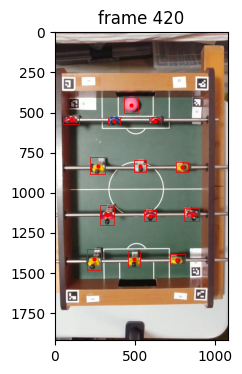

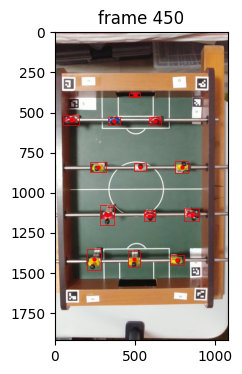

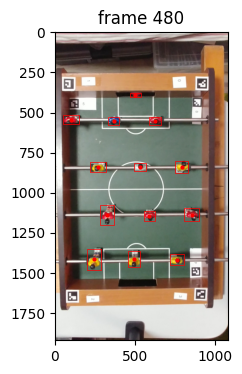

In [22]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    frame_labels = label_array[out_frame_idx]
    for object_idx in range(len(frame_labels)):
        label = frame_labels[object_idx]
        cx = label[0]
        cy = label[1]
        w = label[2]
        h = label[3]
        # negative bounding box - not detected
        if(cx >= 0):
            draw_bounding_box_from_scaled_label(cx, cy, w, h, (1,1), plt.gca())
            plt.plot(cx,cy,'ro', markersize=2)

In [26]:
# get image shape
#image = img.imread('/content/drive/My Drive/Colab Notebooks/rusty.png')
# matplotlib.pyplot.imread()
img_0 = np.asarray(Image.open(os.path.join(video_dir, frame_names[0])))
print(img_0.shape)
height,width = img_0.shape[0], img_0.shape[1]

(1920, 1080, 3)


In [31]:
print(label_array.shape)
print(label_array[0][0])

(501, 13, 4)
[ 496.5 1313.5   89.    91. ]


### Apply scaling


In [32]:
label_array[:,:,0]/=width
label_array[:,:,1]/=height
label_array[:,:,2]/=width
label_array[:,:,3]/=height


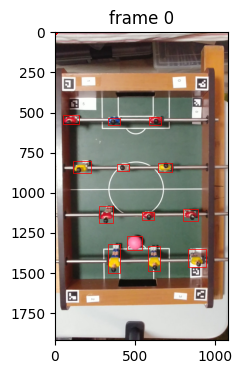

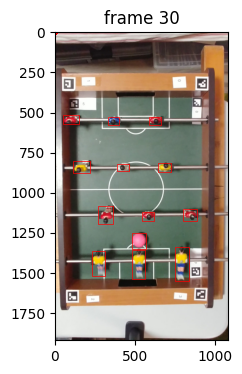

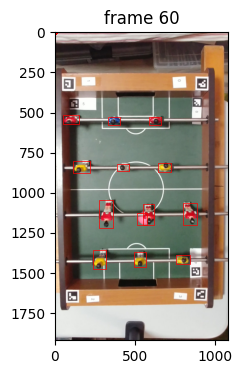

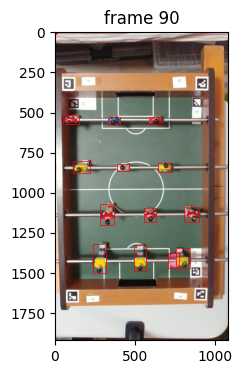

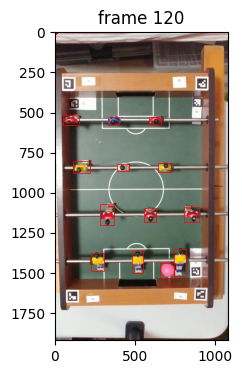

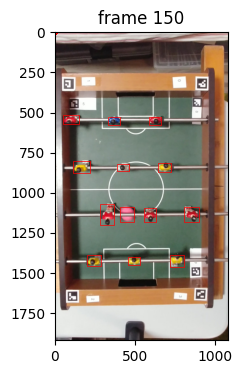

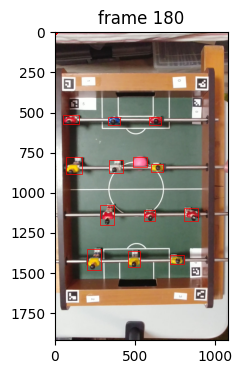

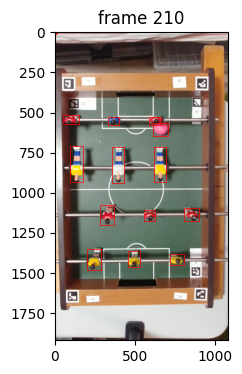

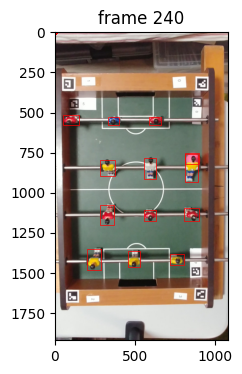

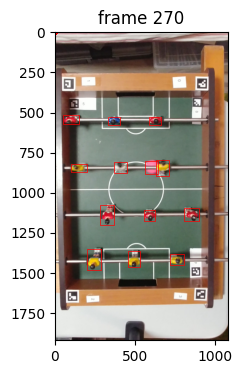

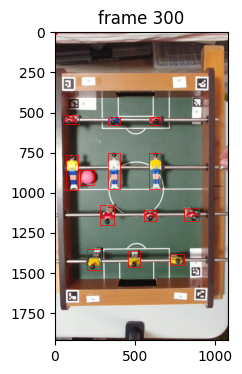

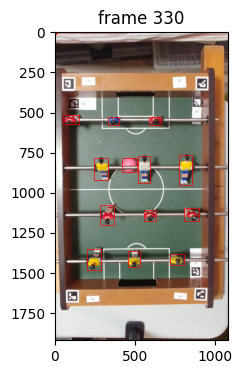

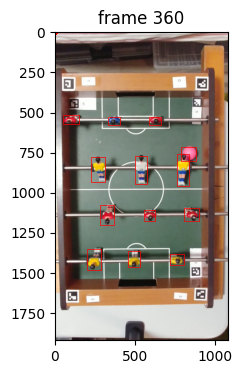

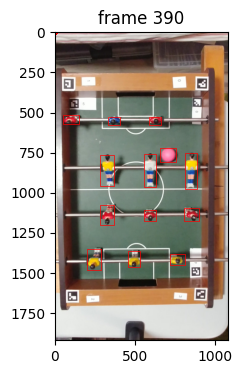

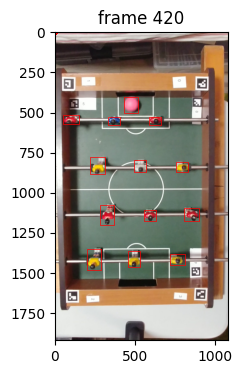

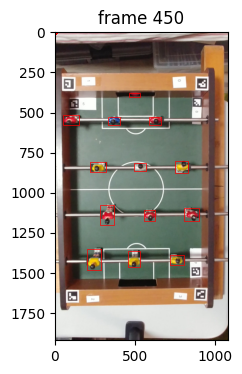

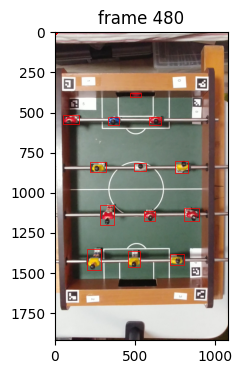

In [33]:
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    frame_labels = label_array[out_frame_idx]
    for object_idx in range(len(frame_labels)):
        label = frame_labels[object_idx]
        cx = label[0]
        cy = label[1]
        w = label[2]
        h = label[3]
        # negative bounding box - not detected
        if(cx >= 0):
            draw_bounding_box_from_scaled_label(cx, cy, w, h, (width,height), plt.gca())
            plt.plot(cx,cy,'ro', markersize=2)

In [44]:
output_dir = "/home/joseph/Documents/git/project/videos/foosball_videos/20221004_220424_labels"

In [45]:
# save labels to files
for frame_idx in range(0, len(frame_names):
    frame_name = frame_names[frame_idx]
    frame_labels = label_array[out_frame_idx]
    write_label_data_to_file(frame_name, output_dir, frame_labels)

TypeError: list indices must be integers or slices, not str

In [ ]:
#torch.cuda.empty_cache()